# Style transfer using GAN
This notebook will be used to prepare the capstone project 'Style transfer using GAN'

In [1]:
#Import all the required libraries
import numpy as np
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import glob


## MRI Image translation Using CycleGAN
This notebook is the solution to the creating style transfer of two type of MRI images, namely T1 and T2.

The combination of the two types of the MRI Images leads to the identification of the required markers from the Scan. There is possibility that only one type of MRI scan is available and the need for the second type cannot be avoided. For the stated reason, we need to be able to create images of second type from the first type.

Following table show the Type of features identified using T1 and T2 type MRI Scans


| Type | T1 Highlight Style | T2 Highlight Style |
| --- | --- | --- |
| Water | Dark | Very Bright |
| Fat | Very Bright | Dark |
| Bone | Dark | Dark |
| Muscle | Intermediate | Dark |
| Tumours | Intermedite | Bright |

## Solution Overview

1. Domain understanding MRI Scan of the Brain.
2. Data Loading
3. Data Visualization - Artifact T1 and T2 MRI Scan.
4. Data Preprocessing
5. Model Building
6. Model Training
7. Model Testing

## Understanding MRI Scans

MRI uses a strong magnetic field and radio waves to create detailed images of the organs and tissues within the body.

Since its invention, doctors and researchers continue to refine MRI techniques to assist in medical procedures and research. The development of MRI revolutionized medicine. An MRI scan uses a large magnet, radio waves, and a computer to create a detailed, cross-sectional image of internal organs and structures.

**T1 Weighted and T2 Weighted MRI Images**

* T1 type image results highlight the fat tissue within the body.
* T2 type image results highlight the fat and water within the body.

Using the combination of the two weighted types of the MRI scans, we are able to identify the regions into the different type of the features, such as water, fat, bone, muscle, tumours. 

In [2]:
# Hyperparameters
batch_size = 8
img_height = 256
img_width = 256
START_EPOCH = 353
END_EPOCHS = 400
LAMBDA = 10.0

## Data understanding
Import the images & create two seperate datasets. The input shape for image should be (256, 256)


In [3]:
data_dir_tr1 = "./dataset/Tr1"
tr1 = tf.keras.preprocessing.image_dataset_from_directory(data_dir_tr1, seed=123, image_size=(img_height, img_width), 
                                                          color_mode='grayscale', 
                                                          batch_size=batch_size)

Found 43 files belonging to 1 classes.


In [4]:
data_dir_tr2 = "./dataset/Tr2"
tr2 = tf.keras.preprocessing.image_dataset_from_directory(data_dir_tr2, seed=123, image_size=(img_height, img_width),
                                                          color_mode='grayscale',
                                                          batch_size=batch_size)

Found 46 files belonging to 1 classes.


## Image Processing 
1.Create a function to process your images with normalisation

2.Apply the function to both the datasets 

3.Visualise the MRI images after processing




In [5]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image/127.5) - 1.0
    return image

In [6]:
# Flipping the images as a step of the Data Augmentation.
def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

### Process both classes of MRI images

In [7]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

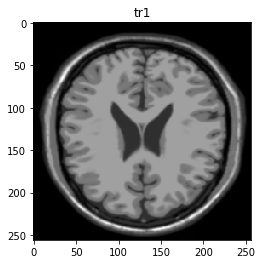

In [8]:
plt.title('tr1')
plt.imshow(sample_tr1[0][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

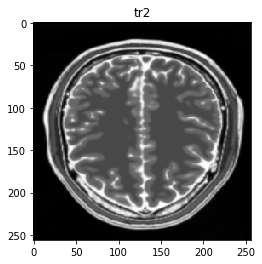

In [9]:
plt.title('tr2')
plt.imshow(sample_tr2[0][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')

## Model Building & Training
The architecture of generator is a modified U-Net.

1.Create your Generator & Discriminator

2.Define the loss functions

3.Create the train_step function

In [10]:
# Custom class for the Instance normalization.
class InstanceNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

# Downsample and the Upsample functions to be used inside the UNet architecture.
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(InstanceNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [11]:
# Network definition of the generator function - UNET architecture
# Thte network to have 4 downsampling layers and 4 upsampling layers.

def unet_generator():
    
    down_stack = [ 
        downsample(64, 4, False), 
        downsample(128, 4), 
        downsample(128, 4), 
        downsample(128, 4), 
        downsample(128, 4)
    ]
    
    up_stack = [        
        upsample(128, 4, True),
        upsample(128, 4, True),
        upsample(128, 4),
        upsample(64, 4)
    ]
        
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 256, 256, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[256, 256, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

### Instantiating the Generator network for both types

In [12]:
generator_g = unet_generator()
generator_f = unet_generator()

In [13]:
# Definition of the discriminator function.
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    x = inp
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down1)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 31, 31, 512)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [14]:
# Instantiating the discriminators
discriminator_x = discriminator()
discriminator_y = discriminator()

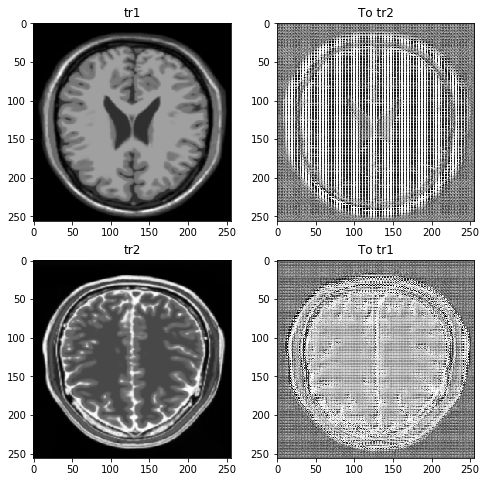

In [15]:
# Check the generator output for the initialization of the g and f.
to_tr2 = generator_g(sample_tr1[0])
to_tr1 = generator_f(sample_tr2[0])
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_tr1, to_tr2, sample_tr2, to_tr1]
title = ['tr1', 'To tr2', 'tr2', 'To tr1']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0][0].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
    else:
        plt.imshow(imgs[i][0].numpy()[:, :, 0] * 0.5 * contrast + 0.5, cmap='gray')
plt.show()

### Defining Loss functions

In [16]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [18]:
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

In [19]:
def calc_cycle_loss(real_image, cycled_image):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss1

In [20]:
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [21]:
# Instantiating the generator and discriminator optimizer

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [27]:
# Checkpointing codebase logic to store the best models.

checkpoint_path = "./Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=END_EPOCHS)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [23]:
def generate_images(model, test_input, expected_output):
    prediction = model(test_input)
    plt.figure(figsize=(10, 10))
    display_list = [test_input[0], prediction[0], expected_output[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

## Model Training Function definition

In [24]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
        
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply the gradients to the generator optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    # Apply gradients to the discriminator optimizer
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

## Model Training 

In [30]:
# Replace 0 with 1 to enable the cell code execution.
if(0):

    for epoch in range(START_EPOCH, END_EPOCHS + 1):
        train_idx = 1
        print(f"Training Epoch : {epoch} ...")
        for t1, t2 in tf.data.Dataset.zip((tr1, tr2)):
            batch_t1, batch_t2 = next(iter(tr1)), next(iter(tr2))
            print(f"Training Step : {train_idx} ...")
            train_step(batch_t1[0], batch_t2[0])
            train_idx +=1
        # Check the generated image, after the use the generator with 1 epoch of training.
        print(f"Generating Image after {epoch} Training ...")
        generate_images(generator_g, sample_tr1[0], sample_tr2[0])
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

## Model Prediction

After training the model for 400 epochs, we are generating the images using trained model shown as below

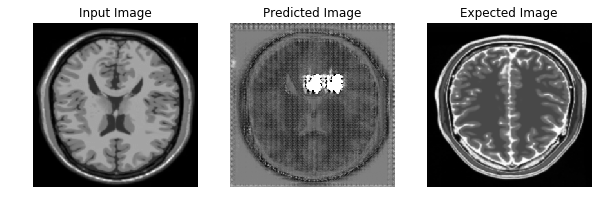

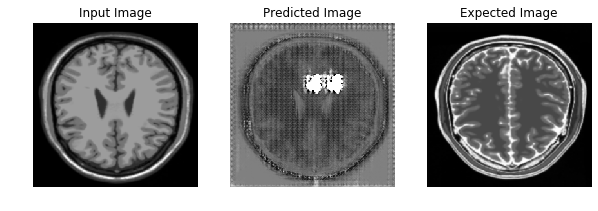

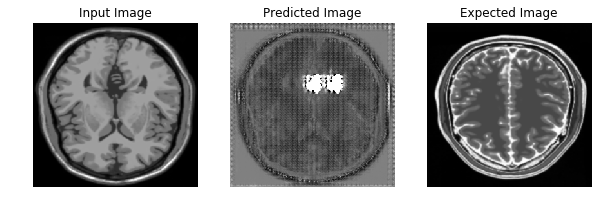

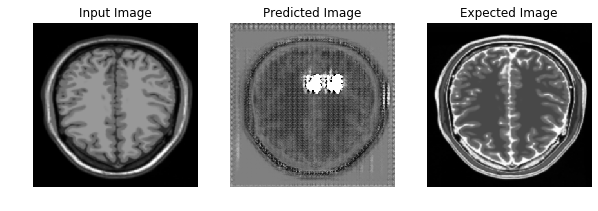

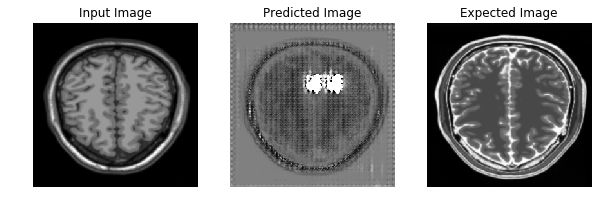

In [29]:
# Run the trained model on the test dataset
# Testing the model with best checkpoint - Epoch - 380
for inp in tr1.take(5):
    generate_images(generator_g, inp[0], sample_tr2[0])